In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from tqdm import tqdm
from cartopy import crs as ccrs

from nzdownscale.dataprocess.config_local import DATA_PATHS
from nzdownscale.dataprocess.config import VAR_ERA5, VAR_STATIONS
from nzdownscale.dataprocess import era5, stations, wrf

/home/emily/mambaforge/envs/deepsensor2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
var = 'humidity'
year = 2020

# Load ERA5

In [4]:
process_era5 = era5.ProcessERA5()
era5_var = VAR_ERA5[var]['var_name']
era5_ds = process_era5.load_ds(var, year)
era5_ds = era5_ds.compute() 

# Load stations

In [5]:
process_stations = stations.ProcessStations()
station_var = VAR_STATIONS[var]['var_name']
station_df = process_stations.load_stations(var, year)

Loading stations:   0%|          | 0/468 [00:00<?, ?it/s]

Filtering stations: 100%|██████████| 211/211 [00:36<00:00,  5.86it/s]


Concatenating stations into pd.DataFrame


In [6]:
len_df = len(station_df)
station_df = station_df.dropna(subset=[station_var])
print(f'Dropped {len_df - len(station_df)} NaN values')
station_df

Dropped 31584 NaN values


relative_humidity
time       station_name       latitude  longitude                   
2020-01-01 AKAROA EWS         -43.80938 172.96574               50.0
           AKITIO EWS         -40.57728 176.44889               45.0
           ALBERT BURN        -44.38112 168.92633               86.0
           ALEXANDRA AWS      -45.21452 169.37549               35.1
           ALEXANDRA EWS      -45.25458 169.38448               61.0
...                                                              ...
2020-12-31 WHANGAREI EWS      -35.74440 174.32868               54.0
           WHITIANGA AERO AWS -36.83237 175.67542               60.0
           WHITIANGA EWS      -36.82817 175.67231               60.0
           WINCHMORE 2 EWS    -43.78935 171.79032               64.0
           WINDSOR EWS        -45.00829 170.82281               70.0

[1615333 rows x 1 columns]

# Plots

In [7]:
era5_mean = float(era5_ds[era5_var].mean(dim=['time', 'latitude', 'longitude']).values)
station_mean = np.mean(station_df[station_var].values)
print(f'ERA5 overall mean: {era5_mean}, \nStation overall mean: {station_mean}')

ERA5 overall mean: 80.55807495117188, 
Station overall mean: 77.49586357735528


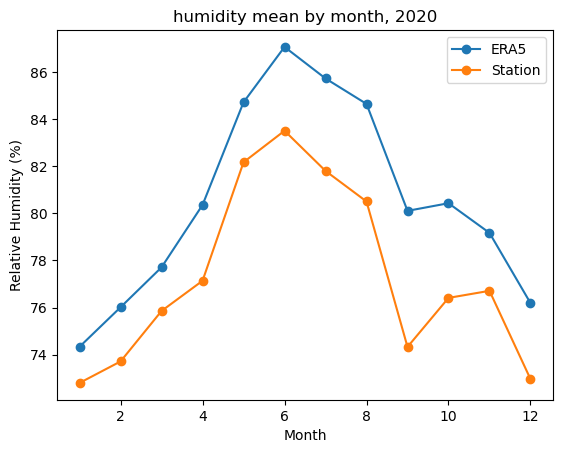

In [8]:
era5_mean_by_month = era5_ds[era5_var].groupby('time.month').mean(dim=['time', 'latitude', 'longitude']).values

station_df_reset = station_df.reset_index()
station_df_reset['time'] = pd.to_datetime(station_df_reset['time'])
station_df_reset = station_df_reset.set_index('time')
station_mean_by_month = station_df_reset[station_var].resample('ME').mean().values

fig, ax = plt.subplots()
ax.plot(np.arange(1, 13), era5_mean_by_month, label='ERA5', marker='o')
ax.plot(np.arange(1, 13), station_mean_by_month, label='Station', marker='o')
ax.set_xlabel('Month')
ax.set_ylabel('Relative Humidity (%)')
ax.legend()
ax.set_title(f'{var} mean by month, {year}')
plt.show();

# By station

In [9]:
stations = station_df_reset['station_name'].unique()

In [10]:
stats_by_station = {}
for station in tqdm(stations):
    station_data = station_df_reset[station_df_reset['station_name'] == station]
    station_data_vals = station_data[station_var]
    station_mean = station_data_vals.mean()
    station_std = station_data_vals.std()

    era5_data = era5_ds[era5_var].sel(latitude=station_data['latitude'].unique()[0],
                                       longitude=station_data['longitude'].unique()[0],
                                       method='nearest')
    era5_data_vals = era5_data.values
    era5_mean = era5_data_vals.mean()
    era5_std = era5_data_vals.std()

    stats_by_station[station] = {'station_mean': station_mean, 
                                 'station_std': station_std,
                                 'era5_mean': era5_mean,
                                 'era5_std': era5_std}

  0%|          | 0/207 [00:00<?, ?it/s]

100%|██████████| 207/207 [00:13<00:00, 15.91it/s]


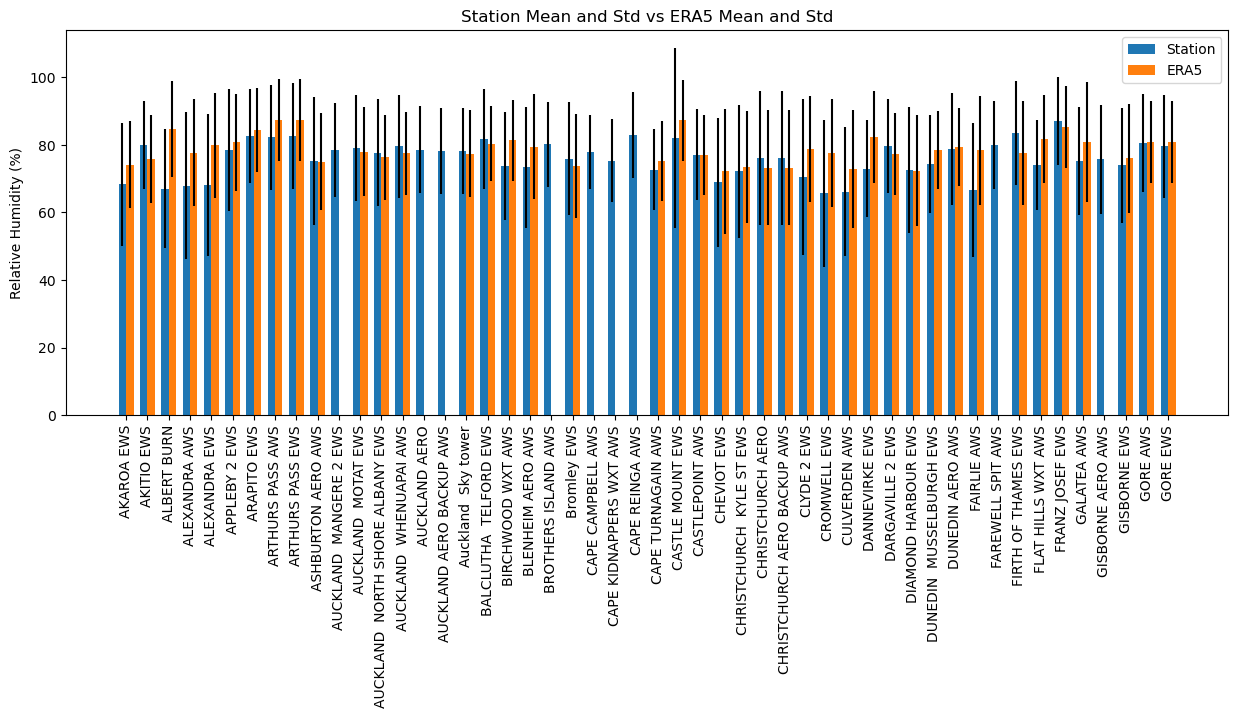

In [11]:
num_stations = len(stats_by_station)

station_names = list(stats_by_station.keys())

station_means = [stats_by_station[station]['station_mean'] for station in station_names]
station_stds = [stats_by_station[station]['station_std'] for station in station_names]

era5_means = [stats_by_station[station]['era5_mean'] for station in station_names]
era5_stds = [stats_by_station[station]['era5_std'] for station in station_names]

bar_width = 0.35
bar_positions = np.arange(num_stations)

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the station means and stds
ax.bar((bar_positions - bar_width/2)[:50], station_means[:50], bar_width, yerr=station_stds[:50], label='Station')
# Plot the era5 means and stds
ax.bar((bar_positions + bar_width/2)[:50], era5_means[:50], bar_width, yerr=era5_stds[:50], label='ERA5')

ax.set_xticks(bar_positions[:50])
ax.set_xticklabels(station_names[:50], rotation=90)

ax.set_ylabel('Relative Humidity (%)')
ax.set_title('Station Mean and Std vs ERA5 Mean and Std')
ax.legend()
plt.show();

# Visualise

In [12]:
cmap = 'YlGnBu'

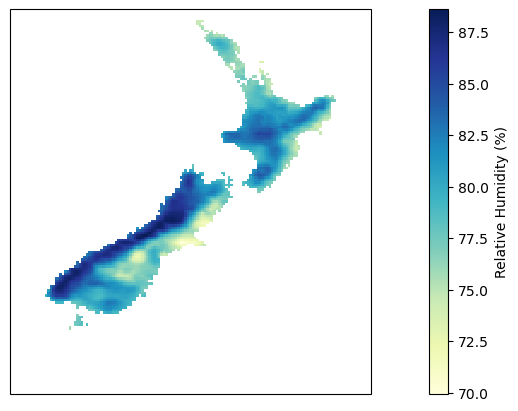

In [13]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
mean_era5 = era5_ds[era5_var].mean(dim='time')
max_era5 = mean_era5.max().values
min_era5 = mean_era5.min().values
mean_era5.plot(ax=ax, 
                cmap=cmap, 
                cbar_kwargs={'label': 'Relative Humidity (%)'},
                vmin=min_era5, vmax=max_era5)
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

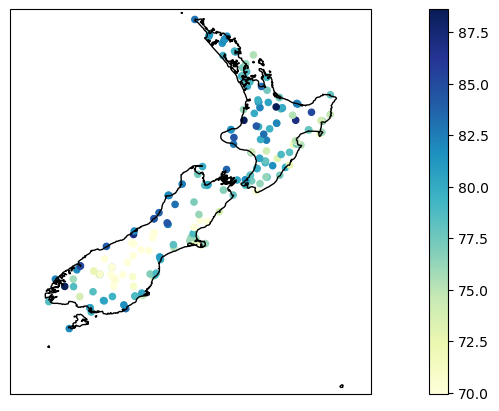

In [14]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
station_means = station_df.groupby(['latitude', 'longitude']).mean().reset_index()
station_means.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_means[station_var], 
                           cmap=cmap,
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)
ax.coastlines()
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

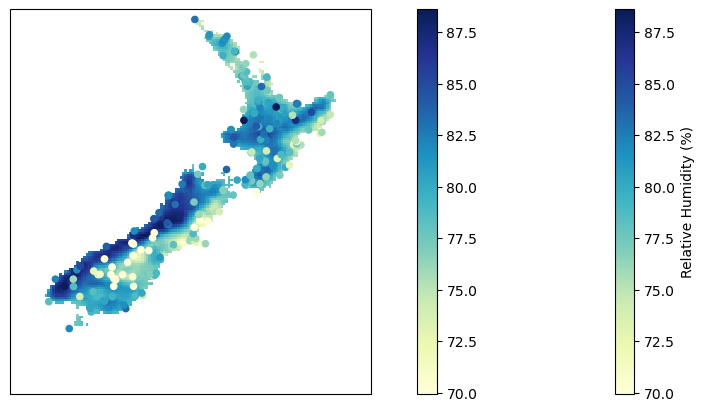

In [15]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})

mean_era5.plot(ax=ax, 
                cmap=cmap, 
                cbar_kwargs={'label': 'Relative Humidity (%)'},
                vmin=min_era5, vmax=max_era5)
station_means.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_means[station_var], 
                           cmap=cmap,
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)

ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())


Text(0.5, 1.0, 'Station Relative Humidity Histogram')

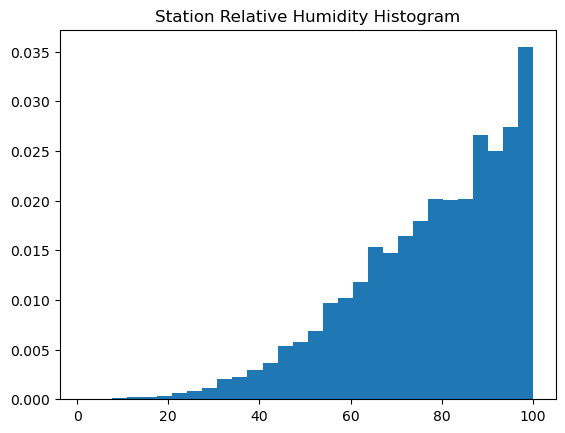

In [23]:
fig, ax = plt.subplots()
ax.hist(station_df['relative_humidity'].values, bins=30, density=True)
ax.set_title('Station Relative Humidity Histogram')